In [1]:
from __future__ import division, print_function, absolute_import

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("./Mask_RCNN")
import math
import cv2
import utils
import model as modellib
from config import Config
import handConfig
from handConfig import HandConfig

import tensorflow as tf

from keras.applications.resnet50 import ResNet50
from keras.backend.tensorflow_backend import set_session
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
from keras.utils.np_utils import to_categorical
from keras.layers import Input
from keras.layers import Dense, Flatten, Dropout
from keras.initializers import RandomNormal
from keras.models import Model
from keras import backend as K
from keras.models import load_model
from keras import metrics
from keras.models import model_from_json

d:\programs\anaconda\envs\python35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
model_dir = "./Mask_RCNN/logs"
model_path = os.path.join(model_dir, "mask_rcnn_hand.h5")

In [3]:
# Create test configuration
class TestConfig(HandConfig):
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.85
    RPN_NMS_THRESHOLD = 0.85

config = TestConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]
 [  8   8]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.85
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_MIN_DIM                  384
IMAGE_PADDING                  True
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           hand
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         

In [4]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=model_dir, config=config)

# Load weights trained on MS-COCO
model.load_weights(model_path, by_name=True)

In [5]:
class_names = ['BG', 'hand']

In [6]:
def detect_img(img, model):
    result = model.detect([img])
    r = result[0]
    opt_index = np.argmax(r['scores'])
    roi = r['rois'][opt_index]
    return roi

In [7]:
def crop_img(img, image, dst, roi):
    h = img.shape[0]
    w = img.shape[1]
    h1 = roi[0]
    w1 = roi[1]
    h2 = roi[2]
    w2 = roi[3]
    
    height = h2-h1
    width = w2-w1
    h_stride = math.ceil(height/8)
    w_stride = math.ceil(width/8)
    
#     adjust height
    
    
    if h1-h_stride < 0:
        hu = 0
        hd = h2+h_stride+(h_stride-h1)
    elif h2+h_stride > h:
        hu = h1-h_stride-(h2+h_stride-h)
        hd = h
    else:
        hu = h1-h_stride
        hd = h2+h_stride

#     adjust width
    
    if w1-w_stride < 0:
        wl = 0
        wr = w2+w_stride+(w_stride-w1)
    elif w2+w_stride > w:
        wl = w1-w_stride-(w2+w_stride-w)           
        wr = w
    else:
        wl = w1-w_stride
        wr = w2+w_stride
        
#     crop image
    box = (wl, hu, wr, hd)
    img_crop = image.crop(box)
    img_crop.save(dst)

In [8]:
# Crop "hand" from test images 
test_path = "./Test_Set/Test_Image"
croped_path = "./Test_Set/Test_Cropped"
if os.path.exists(croped_path) == False:
    os.mkdir(croped_path)
image_list = os.listdir(test_path)
for item in image_list:
    if item.endswith(".jpg"):
        img = cv2.imread(os.path.join(test_path, item))
        roi = detect_img(img, model)
        imPIL = Image.open(os.path.join(test_path, item))
        crop_img(img, imPIL, os.path.join(croped_path, item), roi)

In [9]:
# Display the image
def disp_image(im):
    plt.imshow(im)   
        
    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])

Original images:


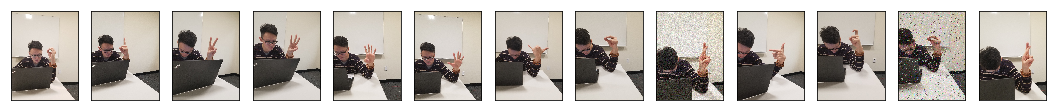

In [18]:
# Display original images
print("Original images:")
plt.figure(figsize=(20,20))
index = 1
for ori in os.listdir(test_path):
    nimage = len(os.listdir(test_path))
    if ori.endswith(".jpg"):
        img = Image.open(os.path.join(test_path, ori))
        plt.subplot(1, nimage, index)
        disp_image(img)
        index += 1
        


Processed images:


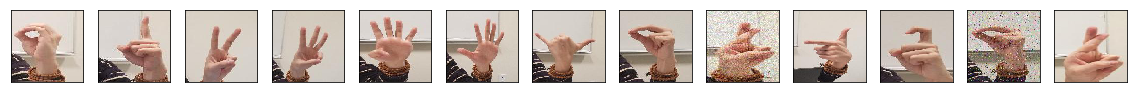

In [22]:
# Display processed images
plt.figure(figsize=(20,20))        
print("Processed images:")
index = 1
for crp in os.listdir(croped_path):
    nimage = len(os.listdir(croped_path))
    if crp.endswith(".jpg"):
        img = Image.open(os.path.join(croped_path, crp)).resize((256,256))
        plt.subplot(1, nimage, index)
        disp_image(img)
        index += 1

In [23]:
# load json file and create model
K.clear_session()

json_file = open('./Weight/model_ResNet.json', 'r')
model = json_file.read()
json_file.close()
model = model_from_json(model)
# load weights into new model
model.load_weights("./Weight/model_ResNet.h5")

In [24]:
# Create test image array
test_list = os.listdir(croped_path)
test_imgs = []
for item in test_list:
    if item.endswith(".jpg"):
        img = Image.open(os.path.join(croped_path, item)).resize((224,224))
        img = np.array(img)
        test_imgs.append(img)

test_imgs = np.array(test_imgs)
img_look = test_imgs
test_imgs = test_imgs.astype('float32')
test_imgs -= np.mean(test_imgs)
test_imgs /= np.max(test_imgs)

In [33]:
# Evaluate on test images
result = model.predict(test_imgs)
pred = np.argmax(result, axis=1)

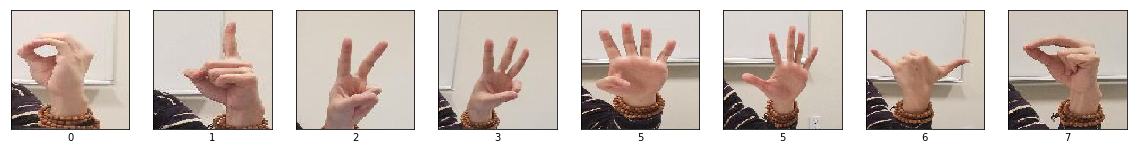

In [35]:
# Show result
plt.figure(figsize=(20,20))
nplot = 8
index = 1
# trick = [0,1,2,3,5,5,6,7]
for index in range(nplot):    
    plt.subplot(1,nplot,index+1)
    disp_image(img_look[index,:,:,:])
    plt.xlabel(str(pred[index]))
#     plt.xlabel(str(trick[index]))